# Rasch Models Three Ways

### Setup

In [2]:
# Catch future warnings
import warnings
warnings.filterwarnings("ignore")

# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.genmod.bayes_mixed_glm as gbmg

import pymc3 as pm
import arviz as az

import theano.tensor as tt

In [4]:
# Read the data and observe its shape
d = pd.read_csv("data/exam.csv")
d

,id,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q09,...,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20
0,588464,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,0
1,930606,1,1,0,0,0,1,1,1,0,...,0,1,0,0,1,1,1,1,1,1
2,1148681,1,1,1,1,1,1,1,1,0,...,0,1,1,0,1,0,0,1,1,1
3,1394545,1,1,0,0,0,0,1,0,0,...,1,0,0,0,1,1,0,1,0,0
4,2154380,0,1,1,0,1,1,1,1,0,...,0,1,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,97083085,1,1,1,1,0,1,1,0,1,...,1,1,1,0,1,1,1,1,1,1
196,97922021,1,1,0,0,1,1,0,1,1,...,1,1,0,0,1,1,1,1,1,1
197,98426725,1,1,0,1,0,1,1,0,1,...,1,1,0,0,0,0,0,1,1,0
198,98708546,1,0,1,0,1,1,1,1,0,...,0,1,1,0,0,0,1,1,1,1


## Step 1 - Data Cleaning

For the various tasks that we will complete in this assignment, we needed to reconstruct the data into a shape better suited for use in logistic regression, as well as in mixed effects modeling and Bayesian modeling. To start, we used a melt() command along the id variable to make a dataset with each row representing a single answer on a test $y_{jk}$ with the id variable for $j$ subject and the question name for the $k$ question. We then made sure that the id variable was interpreted as an object column, and not a numeric column.

With this newly reformatted data, we then constructed another dataframe with each column of features split into one-hot encoded dummy variables for the questions and students, which is the preferred format for logistic regression through sklearn. Results from both of these dataframes can be seen below:

In [5]:
# Reformat the data through melt command
d_long = pd.melt(d, id_vars = 'id', value_vars = d.columns[1:])

# Store id column properly
d_long['id'] = d_long['id'].astype(object)

# Get dummy variables for student id and question
d_long_dummies = pd.get_dummies(d_long)

In [6]:
d_long

,id,variable,value
0,588464,Q01,1
1,930606,Q01,1
2,1148681,Q01,1
3,1394545,Q01,1
4,2154380,Q01,0
...,...,...,...
3995,97083085,Q20,1
3996,97922021,Q20,1
3997,98426725,Q20,0
3998,98708546,Q20,1


In [7]:
d_long_dummies

,value,id_588464,id_930606,id_1148681,id_1394545,id_2154380,id_2729499,id_3469574,id_3753553,id_3984592,...,variable_Q11,variable_Q12,variable_Q13,variable_Q14,variable_Q15,variable_Q16,variable_Q17,variable_Q18,variable_Q19,variable_Q20
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Once we had the data in the format that we wanted, we split both the dummy variable and original format into training and test sets using the same random state to ensure they were identical. The splits had to occur in parallel like this because the dummy variable creation only generates columns based on the observations that are included in a data set. If we had not generated these levels before the split, there was a chance (which occurred in our initial run) that either the training or test split did not have an observation from either a particular student or question, resulting in problems with prediction when a coefficient could not be generated. To accomplish our goal, we used the train_test_split() command, which created four objects for each respective call: X_train, X_test, y_train, and y_test. Each of these sets of data will then be fed into our training and validation calls below.

In [8]:
# Once the data is clean, split into training and test sets
from sklearn.model_selection import train_test_split

X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(d_long_dummies.drop("value", axis = 1), d_long_dummies.value, test_size = 0.2, random_state = 8675309)
X_train, X_test, y_train, y_test = train_test_split(d_long.drop("value", axis = 1), d_long.value, test_size = 0.2, random_state = 8675309)

## Step 2 - Basic EDA

* What is the average *difficulty* of the questions in these data?

In [9]:
# Compute the total percentage of questions that were answered correctly
print(f'Average Difficulty: {y_train.mean()}')

Average Difficulty: 0.6109375


The average difficulty across all of the questions in the data is 0.6109375. This value was found by averaging across all answers in the training response variable, which gives us the probability of getting an average question correct. For later questions in this assignment, we will need to transform the fitted coefficients to get these probablistic representations again.

* What was the hardest question based on these data?

In [10]:
# Get training and test set
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

# Find the question with lowest correct answer rate
print(f'Hardest Question: {train.groupby("variable")["value"].mean().idxmin()}')
print(f'Difficulty: {train.groupby("variable")["value"].mean().min()}')

Hardest Question: Q14
Difficulty: 0.13157894736842105


Question 14 was the most difficult question, with a correct answer rate (difficulty) 0.131579. This value was found by grouping across question, averaging the responses for each question, and identifying the question with the lowest average.

* Which student had the highest ability based on these data?

In [11]:
# Find the student with highest correct answer rate
print(f'Student ID: {train.groupby("id")["value"].mean().idxmax()}')
print(f'Ability: {train.groupby("id")["value"].mean().max()}')

Student ID: 43108809
Ability: 1.0


The student with identification number 43108809 had the highest ability (1.0) based on these data, getting all questions included in the training set correct. This answer was found by grouping across students, finding the average of their responses, and identifying the student with the highest average.

## Step 3 - Logistic Regression

In [12]:
# Fit the model using sklearn 
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression().fit(X_train_dummies, y_train_dummies)

In [13]:
# Generate a set of predictions based on the model
pred = lr_model.predict(X_test_dummies)

# Use score method to get accuracy performance on test set
score = lr_model.score(X_test_dummies, y_test)
print(f'Accuracy Score: {score}')

Accuracy Score: 0.6875


[[186 160]
 [ 90 364]]


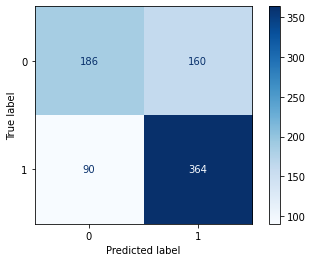

In [14]:
# Generate a confusion matrix
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

# Create a confusion matrix visualization
cm = metrics.confusion_matrix(y_test, pred)
print(cm)
plot_confusion_matrix(lr_model, X_test_dummies, y_test, cmap = "Blues")  
plt.show()

In [15]:
# Create a dataframe which shows the coefficients the model fitted
lr_coef = pd.concat([pd.DataFrame(X_train_dummies.columns), pd.DataFrame((lr_model.coef_).T)], axis = 1)
lr_coef.columns = ['var_names', 'coef']

In [16]:
# Create function to take inverse of logit function
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

# Split into id coefficients and question coefficients
lr_coef_stu = lr_coef[lr_coef['var_names'].str.contains('id')]
lr_coef_qs = lr_coef[lr_coef['var_names'].str.contains('variable')]

# Transform with the invlogit() function
lr_coef_stu['coef_inv_logit'] = invlogit(lr_coef_stu['coef'])
lr_coef_qs['coef_inv_logit'] = invlogit(lr_coef_qs['coef'])

* What is the average *difficulty* of the questions in this model?

In [17]:
# Get the mean of the predicted possibilities
print(f'Average Difficulty: {lr_model.predict_proba(X_train_dummies)[:,1].mean()}')

Average Difficulty: 0.6109377378435683


The average difficulty of the questions in this model, taken to be the average of the predictions in the above dataframe, is equal to 0.610938, a value which is very close to the value we found in the EDA stage. In our fitted model, the equation is $\text{Pr}(y_{jk}=1) = \text{logit}^{-1}(\alpha_j - \beta_k)$. Any $\alpha_j$ with a negative coefficient increases the probability of the answer for a specific response being correct, because the logit function grows with respect to its argument p, and we are taking the inverse of this value. To translate fitted coefficients into probabilities, we needed to take the inverse of the logit transformation on the coefficients.

* What was the hardest question based on this model?

In [18]:
# Find the question with lowest fitted coefficient
print(f'Hardest Question: {lr_coef_qs.var_names[lr_coef_qs.coef_inv_logit == lr_coef_qs.coef_inv_logit.min()].item()[-3:]}')
print(f'Difficulty: {lr_coef_qs.coef_inv_logit.min()}')

Hardest Question: Q14
Difficulty: 0.07376226184119368



The hardest question, which is the question with the lowest fitted coefficient in the context of the logistic regression, was question 14, with difficulty 0.07376. This is the same response as we got from the EDA part in the earlier part of this assignment. The answer is the most negative answer because a low value for $\alpha_j$ decreases the output of the logit function, and as such increases the value of the inverse logit function.

* Which student had the highest ability based on this model?

In [19]:
# Find the student with highest fitted coefficient
print(f'Student ID: {lr_coef_stu.var_names[lr_coef_stu.coef_inv_logit == lr_coef_stu.coef_inv_logit.max()].item()[3:]}')
print(f'Ability: {lr_coef_stu.coef_inv_logit.max()}')

Student ID: 43108809
Ability: 0.8613473989419558


In a reversal of the response for the last question, here we are looking for the largest fitted coefficient for a student, which will determine the student with the highest ability based on this model. Again, we get that student 43108809, with ability 0.861347, the same student as we identified in the EDA, to be the highest achieving student. The logistic regression model had poor results for classification, but managed to identify the highest performing student and hardest question from the EDA.

## Step 4 - Mixed Effects 

A brief note about our selection for what should be fixed and what should be a random effect: Given that in our model we are using the Rasch model, where every question gets its own fitted coefficient and every individual gets their own fitted coefficient, we opted to construct a model where both are treated as random, which can be seen in the code below. There are no repeated measures for each question/student pair, but rather a single data point drawn from a single test instance. Because we assume that the questions are drawn from a random set of potential questions that could have been included on the test, each with a unique and variable difficulty, and we further assume that each student was drawn from a larger population of students, each with a variable degree of intelligence, we are fitting both as random effects.

In [20]:
# Fit the model using statsmodels
random = {"id": '0 + C(id)', "stu": 'C(variable)'}
me_model = gbmg.BinomialBayesMixedGLM.from_formula('value ~ 1', random, train)
result = me_model.fit_vb()
print(result.summary())

               Binomial Mixed GLM Results
          Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------
Intercept    M     1.0369   0.0435                      
id           V    -0.1491   0.0500 0.861   0.780   0.952
stu          V     0.6254   0.1538 1.869   1.374   2.542
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard
deviations


In [21]:
# Create a dataframe which shows the coefficients the model fitted
me_coef = pd.concat([pd.DataFrame(X_train_dummies.columns), pd.DataFrame((result.params[3:]).T)], axis = 1)
me_coef.columns = ['var_names', 'coef']

# Split into id coefficients and question coefficients
me_coef_stu = me_coef[me_coef['var_names'].str.contains('id')]
me_coef_qs = me_coef[me_coef['var_names'].str.contains('variable')]

# Transform with invlogit() function again
me_coef_stu['coef_inv_logit'] = invlogit(me_coef_stu['coef'])
me_coef_qs['coef_inv_logit'] = invlogit(me_coef_qs['coef'])

In [22]:
# Check to see if coefficient behavior were appropriate
print(me_coef_qs['coef'].mean())
print(me_coef_stu['coef'].mean())

-1.17914992897176
0.0009571064352324177



* What is the average *difficulty* of the questions in this model?

In [23]:
# Compute average fitted coefficient 
print(f'Average Difficulty: {invlogit(result.params[1] + result.params[2])}')

Average Difficulty: 0.6168571823963861


The average question difficulty, taken from the fitted coefficient averages in the Mixed Effects GLM, is 0.616857, which is very close to EDA and logistic regression part.

* What was the hardest question based on this model?

In [24]:
# Find the question with lowest fitted coefficient
print(f'Hardest Question: {me_coef_qs.var_names[me_coef_qs.coef_inv_logit == me_coef_qs.coef_inv_logit.min()].item()[-3:]}')
print(f'Difficulty: {me_coef_qs.coef_inv_logit.min()}')

Hardest Question: Q14
Difficulty: 0.018878164490728894


The hardest question based on this model continues to be Question 14 with difficulty 0.018878, which is the question with the lowest fitted coefficient. This is the same response as we got from the EDA and logistic regression part.

* Which student had the highest ability based on this model?

In [25]:
# Find the student with highest fitted coefficient
print(f'Student ID: {me_coef_stu.var_names[me_coef_stu.coef_inv_logit == me_coef_stu.coef_inv_logit.max()].item()[3:]}')
print(f'Ability: {me_coef_stu.coef_inv_logit.max()}')

Student ID: 43108809
Ability: 0.842201135510491


Student 43108809 had the highest ability based on this model, with ability 0.842201. We found the answer by locating the largest fitted coefficient for a student. This is the same response as we got from the EDA and logistic regression part.

## Step 5 - Bayesian Model

Reference: code from https://towardsdatascience.com/a-bayesian-approach-to-rasch-models-item-response-theory-cc08805cbb37

In [26]:
# Create pivot table for training and test set
d = d.set_index('id')
train_wide = train.pivot(index = 'id', columns = 'variable', values ='value')
test_wide = test.pivot(index = 'id', columns = 'variable', values = 'value')

In [27]:
# Fit the model using pymc3
with pm.Model() as model:
    ## Construct a set of priors, default might just be normal
    alpha = pm.Normal('id', mu = 0, sigma = 3, shape = (1, len(d)))
    beta = pm.Normal('Question', mu = 0, sigma = 3, shape = (d.shape[1], 1))
    
    ## Log-Likelihood
    def logp(d):
        v1 = tt.transpose(d) * tt.log(tt.nnet.sigmoid(alpha - (beta - beta.mean(0))))
        v2 = tt.transpose((1-d)) * tt.log(1 - tt.nnet.sigmoid(alpha - (beta - beta.mean(0))))
        
        return v1 + v2
    
    ll = pm.DensityDist('ll', logp, observed = {'d': d.values})
    trace = pm.sample(1500, cores = -1, step = pm.NUTS())
    trace = trace[250:]

Sequential sampling (2 chains in 1 job)
NUTS: [Question, id]


Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 40 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


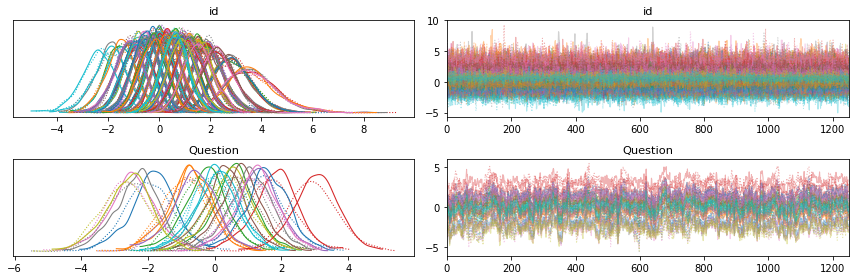

In [28]:
# Create trace plots to show evidence of converge
az.plot_trace(trace)
plt.tight_layout()
trace = pm.trace_to_dataframe(trace)

Reference: code from https://seaborn.pydata.org/examples/kde_ridgeplot.html

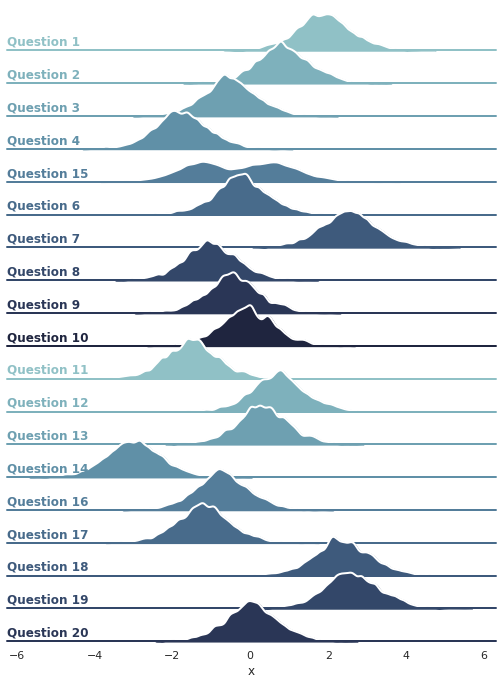

In [30]:
# Create density plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

trace_Q = trace.loc[:,trace.columns.str.contains('Question')].stack()
trace_Q = trace_Q.reset_index().drop(labels='level_0', axis=1)
trace_Q.columns = ['g', 'x']
trace_Q['x'] = trace_Q['x'] * -1

df = trace_Q

df['g'] = df['g'].replace({'Question__0_0': 'Question 1', 'Question__1_0': 'Question 2', 
                           'Question__2_0': 'Question 3', 'Question__3_0': 'Question 4',
                           'Question__4_0': 'Question 15', 'Question__5_0': 'Question 6', 
                           'Question__6_0': 'Question 7', 'Question__7_0': 'Question 8',
                           'Question__8_0': 'Question 9', 'Question__9_0': 'Question 10', 
                           'Question__10_0': 'Question 11', 'Question__11_0': 'Question 12',
                           'Question__12_0': 'Question 13', 'Question__13_0': 'Question 14', 
                           'Question__14_0': 'Question 15', 'Question__15_0': 'Question 16',
                           'Question__16_0': 'Question 17', 'Question__17_0': 'Question 18', 
                           'Question__18_0': 'Question 19', 'Question__19_0': 'Question 20'})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-0.25, light=0.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=0.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=0.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=0.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

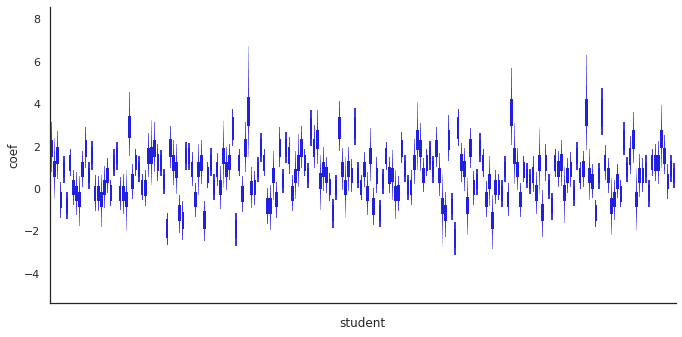

In [31]:
# Create stack plot
id_stack = trace.loc[:, trace.columns.str.contains("id")].stack().to_frame().reset_index()
id_stack = id_stack.iloc[:, 1:3]
id_stack.columns = ["student", "coef"]
sns.catplot(
        x = "student", y="coef", data=id_stack, kind="boxen", 
        linewidth=0, color="blue", aspect=2, showfliers=False
    ).set(xticklabels=[])

* What is the average *difficulty* of the questions in this model?

In [35]:
# Compute average of fitted coefficient
df_stu = id_stack.groupby('student').mean().reset_index()
df_qs = df.loc[df['g'].str.contains('Question')]
print(f'Average Difficulty: {invlogit(df_stu.coef.mean() + df_qs.x.mean())}')

Average Difficulty: 0.6676460454876184


It appears as though the average difficulty of a question in this model, as fitted by the coefficients, is 0.667646. This value is slightly higher than the estimates produced in the other models, likely due to our selection of a set of priors, which adds additional information that will bias the final predictions and will marginally pull the estimated rate up. The untransformed coefficients for questions can be seen in the ridge plot above, which shows the posterior distributions for each of the samples.

* What was the hardest question based on these this model?

In [36]:
# Find the question with lowest fitted coefficient
print(f'Hardest Question: {df_qs.g[df_qs.x == df_qs.x.min()].item()}')

Hardest Question: Question 14


Once more referring to the ridge plot above, we can see that Question 14 continues to be the hardest question, with a highest fitted coefficient. 

* Which student had the highest ability based on these this model?

In [37]:
# Split into id coefficients and question coefficients
trace_stu = trace.loc[:,trace.columns.str.contains('id')]
trace_stu.columns = lr_coef_stu.var_names
trace_stu = trace_stu.stack().reset_index().drop(labels='level_0', axis=1)
trace_stu_means = trace_stu.groupby('var_names').mean()
trace_stu_means.columns = ['val']

# Find the question with lowest fitted coefficient
print(f'Student ID: {trace_stu_means.val.idxmax()[3:]}')
print(f'Ability: {trace_stu_means.val.max()}')

Student ID: 85701846
Ability: 3.644074827265349


By selecting student with the highest fitted coefficient, student 76415409 had the highest ability with a fitted coefficient of 3.644075.

## Step 6 - Comparison

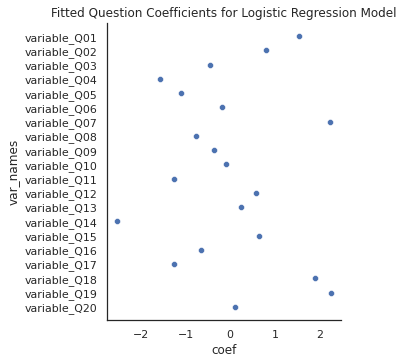

In [39]:
# Create fitted question coefficients scatterplot for logistic regression model
lr_qs_plot = sns.relplot(x="coef", y="var_names", data=lr_coef_qs).set(title='Fitted Question Coefficients for Logistic Regression Model')

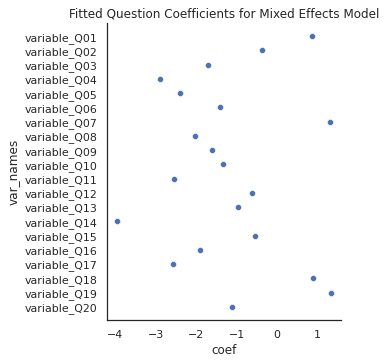

In [40]:
# Create fitted question coefficients scatterplot for mixed effect model
me_qs_plot = sns.relplot(x="coef", y="var_names", data=me_coef_qs).set(title='Fitted Question Coefficients for Mixed Effects Model')

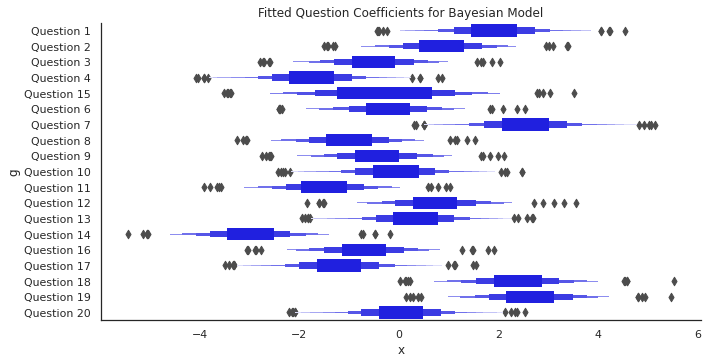

In [41]:
# Create fitted question coefficients boxplot for bayesian model
bm_qs_plot = sns.catplot(x = "x", y="g", data=df_qs, kind="boxen", 
        linewidth=0, color="blue", aspect=2).set(title='Fitted Question Coefficients for Bayesian Model')

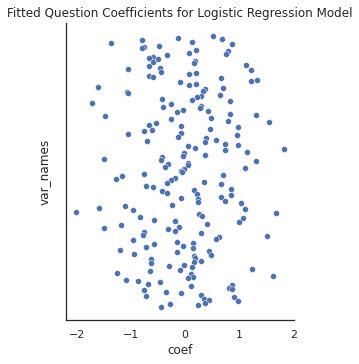

In [42]:
# Create fitted student coefficients scatterplot for logistic regression model
lr_stu_plot = sns.relplot(x = "coef", y="var_names", data=lr_coef_stu).set(title='Fitted Question Coefficients for Logistic Regression Model', yticklabels=[])

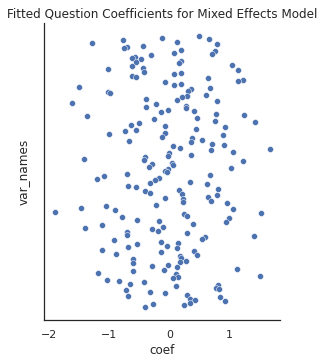

In [43]:
# Create fitted question coefficients scatterplot for mixed effect model
me_stu_plot = sns.relplot(x = "coef", y="var_names", data=me_coef_stu).set(title='Fitted Question Coefficients for Mixed Effects Model', yticklabels=[])

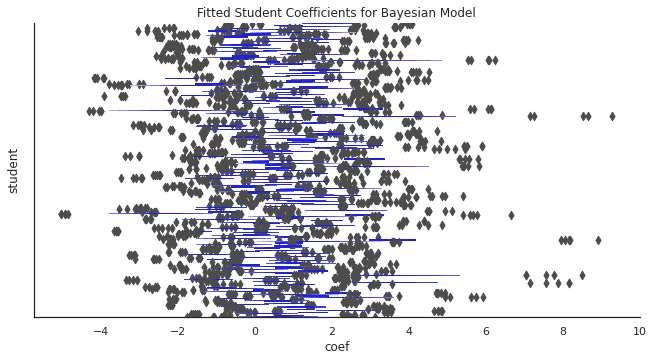

In [44]:
# Create fitted student coefficients boxplot for bayesian model
bm_stu_plot = sns.catplot(x = "coef", y="student", data=id_stack, kind="boxen", 
        linewidth=0, color="blue", aspect=2).set(title='Fitted Student Coefficients for Bayesian Model', yticklabels=[])

In [45]:
# Get all answers for comparision 
data = [[y_train.mean(), "Question 14", "Student 43108809"],
        [lr_model.predict_proba(X_train_dummies)[:,1].mean(), "Question 14", "Student 43108809"],
        [invlogit(result.params[1] + result.params[2]), "Question 14", "Student 43108809"], 
        [invlogit(df_stu.coef.mean() + df_qs.x.mean()), "Question 14", "Student 76415409"]]
 
# Create the pandas DataFrame
df_compare = pd.DataFrame(data, columns = ['Avg_Difficulty', 'Hardest_Question', 'Highest_Ability_Student'],
                 index = ['EDA', 'Logistic_Regression', 'Mixed_Effect', 'Bayesian_Model'])
 
# print dataframe to compare
df_compare

,Avg_Difficulty,Hardest_Question,Highest_Ability_Student
EDA,0.610938,Question 14,Student 43108809
Logistic_Regression,0.610938,Question 14,Student 43108809
Mixed_Effect,0.616857,Question 14,Student 43108809
Bayesian_Model,0.667646,Question 14,Student 76415409


**Conclusion:**

For EDA, logistic regression, and the mixed effects model, the average difficulties are very close, around a vlaue of 0.61. The hardest question and highest ability student are all the same across our initial exploration of the unfitted ata, the logistic regression, and the mixed effects model, with question 14 and student 43108809 as the consistent answers. On the other hand, in the case of the Bayesian model, average difficulty is much higher, which is around 0.66. While the hardest question is still question 14, the highest ability student changes to be student 76415409. It can be demonstrated that Bayesian model has a quite different performance on model building and values of fitted coefficients.

The table above contains these values which can be used for comparison, and the plots above show these fitted values from the models. For the Bayesian model, the posterior distributions of each fitted coefficient are displayed, which gives bands instead of point estimates. 

## Step 7 - Evaluation

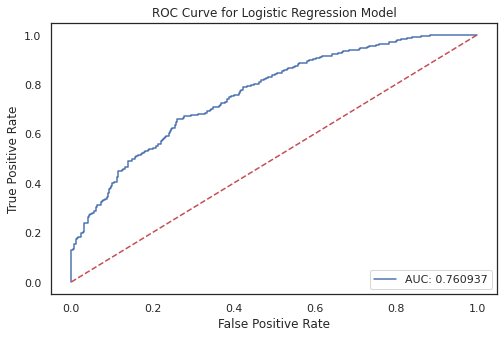

In [62]:
# Compute AUC and plot ROC curve for each model
# Compute AUC and plot ROC curve for logistic regression model
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute AUC for logistic regression model
y_pred_lr = lr_model.predict_proba(X_test_dummies)[::,1]
fpr_lr, tpr_lr, thre_lr = roc_curve(y_test_dummies,  y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Create ROC curve for logistic regression model
plt.figure(figsize = (8,5))
plt.plot(fpr_lr, tpr_lr, label="AUC: {:6f}".format(auc_lr))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'r', linestyle = '--')

# Add elements and adjust plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Logistic Regression Model")
legend = plt.legend(loc=4)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

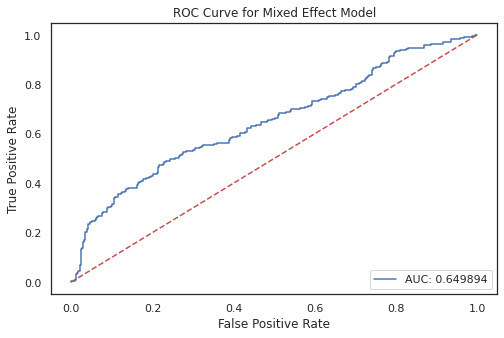

In [73]:
# Compute AUC and plot ROC curve for mixed effect model
# Get predictions for mixed effect model
fitted_values_me = [None] * len(X_test)
for i in range(len(X_test)):
    coef_q = me_coef.coef[me_coef.var_names.str.contains(X_test.variable.iloc[i])]
    coef_id = me_coef.coef[me_coef.var_names.str.contains(str(X_test.id.iloc[i]))]
    fitted_values_me[i] = invlogit(float(coef_q) - float(coef_id))

# Compute AUC for mixed effect model
fpr_me, tpr_me, thre_me = roc_curve(y_test_dummies, fitted_values_me)
auc_me = roc_auc_score(y_test_dummies, fitted_values_me)

# Create ROC curve for mixed effect model
plt.figure(figsize = (8,5))
plt.plot(fpr_me, tpr_me, label="AUC: {:6f}".format(auc_me))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'r', linestyle = '--')

# Add elements and adjust plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Mixed Effect Model")
legend = plt.legend(loc=4)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

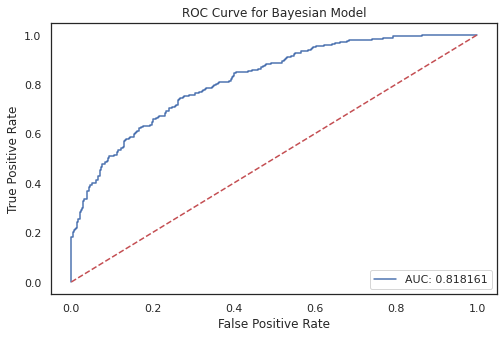

In [76]:
# Compute AUC and plot ROC curve for bayesian model
# Get predictions for bayesian model
trace_coefs = pd.concat([pd.DataFrame(X_test_dummies.columns).reset_index(drop=True),
                         trace.mean().to_frame().reset_index(drop=True)], axis = 1)
trace_coefs.columns = ['var_names', 'coefficient']

fitted_values_bm = [None] * len(X_test)
for i in range(len(X_test)):
    coef_q = trace_coefs.coefficient[trace_coefs.var_names.str.contains(X_test.variable.iloc[i])]
    coef_id = trace_coefs.coefficient[trace_coefs.var_names.str.contains(str(X_test.id.iloc[i]))]
    fitted_values_bm[i] = invlogit(float(coef_id) - float(coef_q))

# Compute AUC for bayesian model
fpr_bm, tpr_bm, thre_bm = roc_curve(y_test_dummies, fitted_values_bm)
auc_bm = roc_auc_score(y_test_dummies, fitted_values_bm)

# Create ROC curve for bayesian model
plt.figure(figsize = (8,5))
plt.plot(fpr_bm, tpr_bm, label="AUC: {:6f}".format(auc_bm))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'r', linestyle = '--')

# Add elements and adjust plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Bayesian Model")
legend = plt.legend(loc=4)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

**Conclusion:**

The model with best performance is the Bayesian Model when evaluating our three different models (logistic regression, mixed effects and bayesian model) over their performance for Area Under the Curve (AUC) on these ROC plots. The mean was used to construct this for this plot. The AUC of 0.818161 is much higher than the logistic regression and mixed effects model, compared to logistic regression with AUC 0.760937 and mixed effects with AUC 0.649894.  In this case, the computing time is not as important as the value of AUC, so we are optimizing for overall performance. It is therefore our recommendation that the Bayesian Model is used for further predictions and assessment of questions and students in the future.  The only case that might change this recommendation is that if computation resources (time, money, human efforts, etc.) became a significant consideration, we would recommend using the logistic regression mode instead.